In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns, warnings

%matplotlib inline
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
plt.rc('font', family='NanumGothic')
rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

plt.style.use('ggplot')
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

warnings.filterwarnings(action='ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [2]:
df_raw = pd.read_csv('../data/jeju_data_ver1/201901-202003.csv')

In [3]:
df_raw.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


# 제주 데이터만 추출

In [259]:
df = df_raw[df_raw['CARD_SIDO_NM']=='제주']

In [260]:
df.fillna('세종시', inplace=True)

In [261]:
df.columns

Index(['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM',
       'HOM_CCG_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CSTMR_CNT', 'AMT', 'CNT'],
      dtype='object')

In [262]:
df.drop(['CARD_CCG_NM','HOM_SIDO_NM','HOM_CCG_NM'], axis=1, inplace=True)

In [263]:
df = df.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC']).sum().reset_index()

In [264]:
df['CV'] = 0
df.loc[df['REG_YYMM']==202001, 'CV'] = 1
df.loc[df['REG_YYMM']==202002, 'CV'] = 2
df.loc[df['REG_YYMM']==202003, 'CV'] = 3

In [265]:
jeju = df.groupby(['REG_YYMM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC'])['AMT', 'CNT'].sum().reset_index()

In [266]:
jeju['DATE'] = pd.to_datetime(jeju['REG_YYMM'], format='%Y%m')

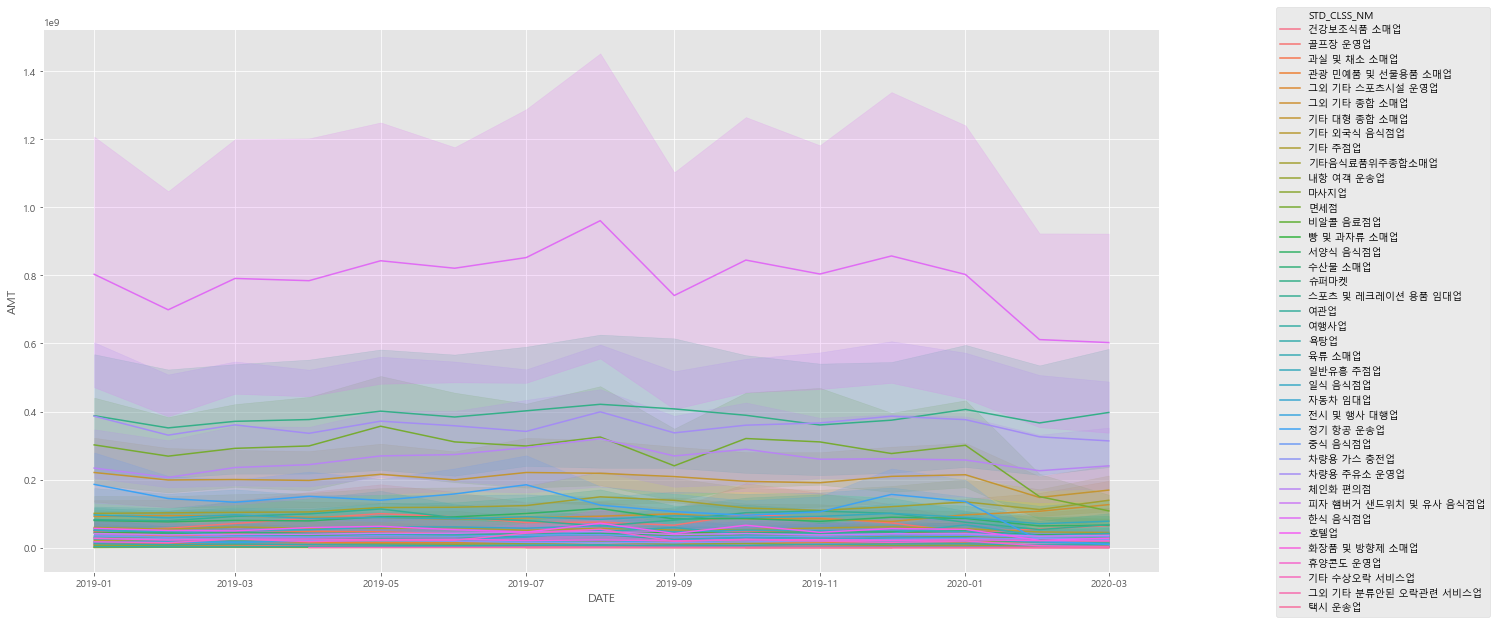

In [267]:
plt.figure(figsize=(20,10))
sns.lineplot(data=jeju, x='DATE', y='AMT', hue='STD_CLSS_NM')
plt.legend(bbox_to_anchor=(1.1, 1.05))

# 전월 대비 증감률 생성

In [298]:
jeju_1 = jeju.groupby(['REG_YYMM', 'STD_CLSS_NM'])['AMT', 'CNT'].sum().reset_index()

In [272]:
tmp = jeju_1.pivot_table(index='REG_YYMM', columns='STD_CLSS_NM', values='AMT', aggfunc='sum').apply(lambda x: x.diff() / x * 100).fillna(0)

stack_AMT_diff = tmp.stack().reset_index().rename(columns={0:'AMT_diff'})

stack_AMT_diff

In [275]:
tmp = jeju_1.pivot_table(index='REG_YYMM', columns='STD_CLSS_NM', values='CNT', aggfunc='sum').apply(lambda x: x.diff() / x * 100).fillna(0)

stack_CNT_diff = tmp.stack().reset_index().rename(columns={0:'CNT_diff'})

stack_CNT_diff

In [278]:
CLSS_df = pd.merge(stack_AMT_diff, stack_CNT_diff, on=['REG_YYMM', 'STD_CLSS_NM'])

CLSS_df = CLSS_df[CLSS_df['REG_YYMM'].isin([202003])].groupby(['STD_CLSS_NM'])['AMT_diff','CNT_diff'].sum()

CLSS_df

# 군집분석

In [279]:
CLSS_df.reset_index(inplace=True)

In [280]:
cl_df = CLSS_df[['AMT_diff', 'CNT_diff']]
cl_df.tail()

,AMT_diff,CNT_diff
35,7.733955,6.021280
36,-1.448491,0.456116
37,5.290249,-11.101766
38,-5.422968,-4.507842
39,-151.484726,-62.955665


#### 표준화 및 역할 정의

In [281]:
X_list = list(cl_df.columns)
# 데이터 표준화
scaler = StandardScaler()
new_df_x = scaler.fit_transform(cl_df[X_list])

## k-평균 군집분석

#### 군집 개수 찾기 : 각 데이터로부터 가장 가까운 군집 중심점까지의 거리 제곱합


In [282]:
# 최대 군집 생성 개수
n_iter_cluster = 5
cluster_range = [i+1 for i in range(n_iter_cluster)]
clus_error = []
for v_n_clus in cluster_range : 
    clus = KMeans(v_n_clus)
    clus.fit(new_df_x)
    # 각 데이터로 부터 가장 가까운 군집 중심점까지 거리 제곱합
    clus_error.append(clus.inertia_)
ds_error = pd.DataFrame({'NumberofCluster' : cluster_range,
                        'Error' : clus_error})
ds_error

,NumberofCluster,Error
0,1,80.000000
1,2,21.262769
2,3,15.706025
3,4,11.049263
4,5,7.327275


#### 4-2) 군집별 군집 중시점까지 거리 제곱합 시각화

Text(0, 0.5, 'Sum of squared distance')

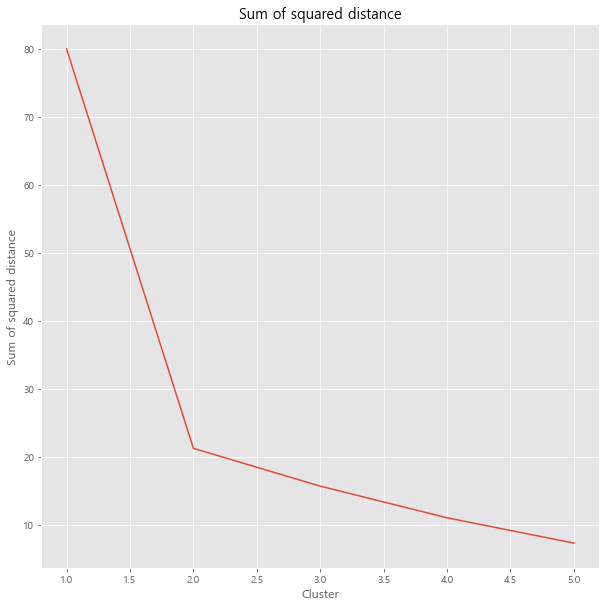

In [283]:
plt.figure(figsize = (10,10))
plt.plot(ds_error['NumberofCluster'], ds_error['Error'])
plt.title("Sum of squared distance")
plt.xlabel('Cluster')
plt.ylabel('Sum of squared distance')

#### 4-3) k-평균 군집 번호 생성

In [284]:
clus = KMeans(n_iter_cluster)
clus.fit(new_df_x)
cluster_kmeans = [i+1 for i in clus.labels_]
CLSS_df['ClusterKmeans'] = cluster_kmeans
CLSS_df.head()

,STD_CLSS_NM,AMT_diff,CNT_diff,ClusterKmeans
0,건강보조식품 소매업,-8.506718,-2.475248,2
1,골프장 운영업,24.369727,30.059546,5
2,과실 및 채소 소매업,-12.129425,8.772992,2
3,관광 민예품 및 선물용품 소매업,-82.338683,-80.765595,4
4,그외 기타 분류안된 오락관련 서비스업,-97.208931,-105.000000,1


#### 4-4) k-평균 군집별 데이터 요약

In [285]:
ds_summary_km = CLSS_df.groupby("ClusterKmeans").agg(['min','mean','max'])
level0 = ds_summary_km.columns.get_level_values(0)
level1 = ds_summary_km.columns.get_level_values(1)
ds_summary_km.columns = level0 + '_' + level1
ds_summary_km.reset_index(inplace = True)
ds_summary_km.round(3)

,ClusterKmeans,AMT_diff_min,AMT_diff_mean,AMT_diff_max,CNT_diff_min,CNT_diff_mean,CNT_diff_max
0,1,-149.850,-123.530,-97.209,-123.973,-114.487,-105.000
1,2,-45.830,-1.376,24.827,-11.102,0.927,10.287
2,3,-174.599,-163.042,-151.485,-62.956,-48.719,-34.483
3,4,-82.339,-65.043,-50.408,-80.766,-58.807,-42.254
4,5,12.542,29.125,73.312,11.111,25.947,61.364


In [286]:
CLSS_df[CLSS_df['ClusterKmeans']==1].sort_values(by='AMT_diff',ascending=False)

,STD_CLSS_NM,AMT_diff,CNT_diff,ClusterKmeans
4,그외 기타 분류안된 오락관련 서비스업,-97.208931,-105.000000,1
29,정기 항공 운송업,-149.850388,-123.973144,1


In [287]:
CLSS_df[CLSS_df['ClusterKmeans']==2].sort_values(by='AMT_diff',ascending=False)

,STD_CLSS_NM,AMT_diff,CNT_diff,ClusterKmeans
23,욕탕업,24.827214,0.814146,2
7,기타 대형 종합 소매업,12.743949,9.497219,2
16,빵 및 과자류 소매업,8.461428,10.278403,2
19,슈퍼마켓,7.754317,10.287121,2
35,피자 햄버거 샌드위치 및 유사 음식점업,7.733955,6.021280,2
33,체인화 편의점,5.942693,4.565491,2
37,호텔업,5.290249,-11.101766,2
18,수산물 소매업,4.300176,-10.874794,2
30,중식 음식점업,4.082726,4.765865,2
15,비알콜 음료점업,3.940352,7.352619,2


In [288]:
CLSS_df[CLSS_df['ClusterKmeans']==3].sort_values(by='AMT_diff',ascending=False)

,STD_CLSS_NM,AMT_diff,CNT_diff,ClusterKmeans
39,휴양콘도 운영업,-151.484726,-62.955665,3
22,여행사업,-174.598841,-34.482759,3


In [289]:
CLSS_df[CLSS_df['ClusterKmeans']==4].sort_values(by='AMT_diff',ascending=False)

,STD_CLSS_NM,AMT_diff,CNT_diff,ClusterKmeans
14,면세점,-50.408030,-53.401449,4
28,전시 및 행사 대행업,-62.383404,-42.254038,4
3,관광 민예품 및 선물용품 소매업,-82.338683,-80.765595,4


In [290]:
CLSS_df[CLSS_df['ClusterKmeans']==5].sort_values(by='AMT_diff',ascending=False)

,STD_CLSS_NM,AMT_diff,CNT_diff,ClusterKmeans
8,기타 수상오락 서비스업,73.311757,61.363636,5
13,마사지업,40.977444,11.111111,5
34,택시 운송업,40.819359,39.743590,5
1,골프장 운영업,24.369727,30.059546,5
20,스포츠 및 레크레이션 용품 임대업,21.365622,19.587568,5
11,기타음식료품위주종합소매업,19.581639,19.285171,5
6,그외 기타 종합 소매업,15.458719,15.341213,5
24,육류 소매업,13.695586,19.111133,5
12,내항 여객 운송업,12.542479,17.915905,5


In [291]:
clss_dict = dict()
for i in range(n_iter_cluster):
    clss_dict[i] = list(CLSS_df[CLSS_df['ClusterKmeans']==i+1]['STD_CLSS_NM'].values)

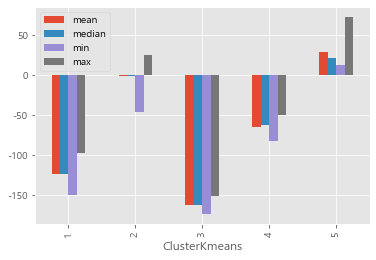

In [292]:
CLSS_df.groupby('ClusterKmeans')['AMT_diff'].agg(['mean','median', 'min', 'max']).plot(kind='bar')

In [293]:
cl1 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[0])]
cl2 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[1])]
cl3 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[2])]
cl4 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[3])]
cl5 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[4])]

In [294]:
cl1.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,CV
590,201901,제주,정기 항공 운송업,20s,1,1,1745,316307962,1728,0
591,201901,제주,정기 항공 운송업,20s,1,2,134,26026742,144,0
592,201901,제주,정기 항공 운송업,20s,2,1,2250,395638789,2293,0
593,201901,제주,정기 항공 운송업,20s,2,2,309,53189601,295,0
594,201901,제주,정기 항공 운송업,30s,1,1,254,49299528,268,0


In [295]:
cl1.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,CV
590,201901,제주,정기 항공 운송업,20s,1,1,1745,316307962,1728,0
591,201901,제주,정기 항공 운송업,20s,1,2,134,26026742,144,0
592,201901,제주,정기 항공 운송업,20s,2,1,2250,395638789,2293,0
593,201901,제주,정기 항공 운송업,20s,2,2,309,53189601,295,0
594,201901,제주,정기 항공 운송업,30s,1,1,254,49299528,268,0


In [297]:
cl1.to_csv('../Jeju/cl1.csv', index=False, encoding='utf-8-sig')
cl2.to_csv('../Jeju/cl2.csv', index=False, encoding='utf-8-sig')
cl3.to_csv('../Jeju/cl3.csv', index=False, encoding='utf-8-sig')
cl4.to_csv('../Jeju/cl4.csv', index=False, encoding='utf-8-sig')
cl5.to_csv('../Jeju/cl5.csv', index=False, encoding='utf-8-sig')